In [10]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import os

# Suppress minor warnings for clean output
warnings.filterwarnings("ignore")

# -----------------------------------------------------------
# ---------- CONFIG (No Change) ----------
# -----------------------------------------------------------
DATA_PATH = "datasets/cleaned/merged_fx_dataset.csv"
OUT_DIR = "./"
TEST_FRACTION = 0.2
Y_COL = "Buying"
TARGET_DLOG_COL = f"{Y_COL}_DLOG"
RANDOM_STATE = 42


# -----------------------------------------------------------
# ---------- HELPERS (Minor Refinements) ----------
# -----------------------------------------------------------

def evaluate_metrics(y_true, y_pred):
    """Calculates standard regression metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    # Using a minimum absolute value (1e-6) to prevent division by zero near parity
    mape = float(np.mean(np.abs((np.asarray(y_true) - np.asarray(y_pred)) /
                                np.maximum(np.abs(y_true), 1e-6))) * 100.0)
    return {"MAE": mae, "RMSE": rmse, "R2": r2, "MAPE_%": mape}


def make_ml_features(frame: pd.DataFrame, y_col="y", max_lag=5, roll_windows=(5, 10)):
    """
    Refactored Feature Engineering: Creates robust time series features.
    """
    out = frame.copy()

    # 1. Target (Y) Lags: The most crucial time series features
    for L in range(1, max_lag + 1):
        out[f"{y_col}_lag{L}"] = out[y_col].shift(L)

    # 2. Exogenous Lags
    ex_cols = [c for c in frame.columns if c != y_col]
    for L in range(1, 3):
        for c in ex_cols:
            out[f"{c}_lag{L}"] = out[c].shift(L)

    # 3. Rolling Statistics on Target (Volatility Signal)
    for w in roll_windows:
        out[f"{y_col}_rollmean_{w}"] = out[y_col].rolling(w).mean()
        out[f"{y_col}_rollstd_{w}"] = out[y_col].rolling(w).std()

    return out


def invert_dlog_to_level(dlog_series: pd.Series, start_log_value: float) -> pd.Series:
    """Reconstruct levels from Δlog series given the last pre-period log level."""
    cumlog = np.cumsum(dlog_series.values) + start_log_value
    return pd.Series(np.exp(cumlog), index=dlog_series.index, name="Level")


# -----------------------------------------------------------
# ---------- 1) LOAD & INITIAL CLEANING (Original) ----------
# -----------------------------------------------------------

print("--- 1) Loading and Initial Cleaning ---")
try:
    df = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    print(f"ERROR: Dataset not found at {DATA_PATH}. Please verify the path.")
    DATA_PATH = "merged_fx_dataset.csv"
    df = pd.read_csv(DATA_PATH)

assert "Date" in df.columns and Y_COL in df.columns, "Dataset must have 'Date' and target column."
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").drop_duplicates("Date").set_index("Date")

df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)
print(f"Data loaded with {len(df)} entries.")


# -----------------------------------------------------------
# ---------- 2) Data Preprocessing: Log-Differencing (ΔLog) ----------
# -----------------------------------------------------------

print("--- 2) Data Preprocessing (ΔLog Transformation) ---")

# --- FIX START: Preserve the original price level data ---
# Rationale: We MUST keep the original 'Buying' column separate for the final
# level reconstruction, otherwise we get KeyError.
df_levels = df[[Y_COL]].copy()
# --- FIX END ---

# 2.1 Target Transformation: Δlog(Y_t) = log(Y_t) - log(Y_{t-1})
df[TARGET_DLOG_COL] = np.log(df[Y_COL]).diff()

# 2.2 Exogenous Feature Transformation: Log-Transform the features
features_to_transform = [c for c in df.columns if c !=
                         Y_COL and c != TARGET_DLOG_COL and df[c].min() > 0]
for col in features_to_transform:
    df[col] = np.log(df[col])

# Drop original level columns (which caused the KeyError)
# We drop Y_COL here because we are moving to the log-difference space for modeling.
df.drop(columns=[c for c in df.columns if c not in features_to_transform and c !=
        TARGET_DLOG_COL], inplace=True)
df.dropna(inplace=True)
print(
    f"Transformed data has {len(df)} entries. Ready for feature engineering.")


# -----------------------------------------------------------
# ---------- 3) Feature Engineering: Lags & Volatility (Refactored) ----------
# -----------------------------------------------------------

print("--- 3) Feature Engineering: Lags & Volatility ---")

df_features = make_ml_features(df, y_col=TARGET_DLOG_COL)

df_features.dropna(inplace=True)

X = df_features.drop(columns=[TARGET_DLOG_COL])
y = df_features[TARGET_DLOG_COL]

print(
    f"Final feature set shape: X={X.shape}, y={y.shape}. Dropped {len(df_levels)-len(y)} initial rows.")


# -----------------------------------------------------------
# ---------- 4) Train/Test Split (Temporal Split) ----------
# -----------------------------------------------------------

print("--- 4) Train/Test Split ---")
test_size = int(len(df_features) * TEST_FRACTION)
train_size = len(df_features) - test_size

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(
    f"Train Period: {X_train.index.min().date()} to {X_train.index.max().date()} ({len(X_train)} rows)")
print(
    f"Test Period: {X_test.index.min().date()} to {X_test.index.max().date()} ({len(X_test)} rows)")


# -----------------------------------------------------------
# ---------- 5) Hyperparameter Optimization (HPO) & Training (Refactored) ----------
# -----------------------------------------------------------

print("\n--- 5) Hyperparameter Optimization (HPO) & Training ---")

xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        objective='reg:squarederror'
    ))
])

param_dist = {
    'xgb__n_estimators': randint(low=100, high=1000),
    'xgb__learning_rate': uniform(loc=0.01, scale=0.19),
    'xgb__max_depth': randint(low=3, high=8),
    'xgb__subsample': uniform(loc=0.7, scale=0.3),
    'xgb__colsample_bytree': uniform(loc=0.7, scale=0.3),
    'xgb__gamma': [0, 0.1, 0.5, 1],
}

tscv = TimeSeriesSplit(n_splits=5)
N_ITER = 12
print(
    f"Starting RandomizedSearchCV with {N_ITER} iterations and TimeSeriesSplit (5 folds)...")

random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_dist,
    n_iter=N_ITER,
    cv=tscv,
    scoring='r2',
    verbose=0,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_xgb_model = random_search.best_estimator_

print("\n--- HPO Results ---")
print(f"Best R2 from Cross-Validation: {random_search.best_score_:.4f}")
print("Best parameters found:")
for k, v in random_search.best_params_.items():
    print(f"  {k}: {v:.4f}")

y_pred_xgb = best_xgb_model.predict(X_test)


# -----------------------------------------------------------
# ---------- 6) Evaluation and Visualization (Fixed) ----------
# -----------------------------------------------------------

print("\n--- 6) Final Test Set Evaluation ---")
y_pred_rw = np.zeros_like(y_test)

xgb_metrics = evaluate_metrics(y_test, y_pred_xgb)
rw_metrics = evaluate_metrics(y_test, y_pred_rw)

print(f"\n{'Metric':<10} | {'XGBoost (Optimized)':<20} | {'Random Walk (Benchmark)':<25}")
print("-" * 60)
for metric in xgb_metrics.keys():
    print(
        f"{metric:<10} | {xgb_metrics[metric]:<20.6f} | {rw_metrics[metric]:<25.6f}")

--- 1) Loading and Initial Cleaning ---
Data loaded with 3703 entries.
--- 2) Data Preprocessing (ΔLog Transformation) ---
Transformed data has 3702 entries. Ready for feature engineering.
--- 3) Feature Engineering: Lags & Volatility ---
Final feature set shape: X=(3599, 66), y=(3599,). Dropped 104 initial rows.
--- 4) Train/Test Split ---
Train Period: 2008-01-16 to 2020-01-13 (2880 rows)
Test Period: 2020-01-14 to 2022-12-01 (719 rows)

--- 5) Hyperparameter Optimization (HPO) & Training ---
Starting RandomizedSearchCV with 12 iterations and TimeSeriesSplit (5 folds)...

--- HPO Results ---
Best R2 from Cross-Validation: 0.2202
Best parameters found:
  xgb__colsample_bytree: 0.8124
  xgb__gamma: 0.0000
  xgb__learning_rate: 0.0449
  xgb__max_depth: 7.0000
  xgb__n_estimators: 120.0000
  xgb__subsample: 0.7468

--- 6) Final Test Set Evaluation ---

Metric     | XGBoost (Optimized)  | Random Walk (Benchmark)  
------------------------------------------------------------
MAE        | 0

In [11]:
print("\n--- Level Reconstruction for Visualization ---")
# --- FIX START: Correctly retrieve the log-level starter value ---
# Rationale: The starter level is the log of the actual price on the last date
# of the training set (X_train.index[-1]). We use df_levels for this.
last_train_date = X_train.index[-1]
last_train_log_level = np.log(df_levels.loc[last_train_date, Y_COL])
# --- FIX END ---

# Invert XGBoost predictions
xgb_level = invert_dlog_to_level(pd.Series(y_pred_xgb, index=X_test.index),
                                 last_train_log_level)

# Invert Random Walk predictions
rw_level = invert_dlog_to_level(pd.Series(y_pred_rw, index=X_test.index),
                                last_train_log_level)

# Actual levels from the preserved data
true_level = df_levels[Y_COL].loc[X_test.index]


--- Level Reconstruction for Visualization ---


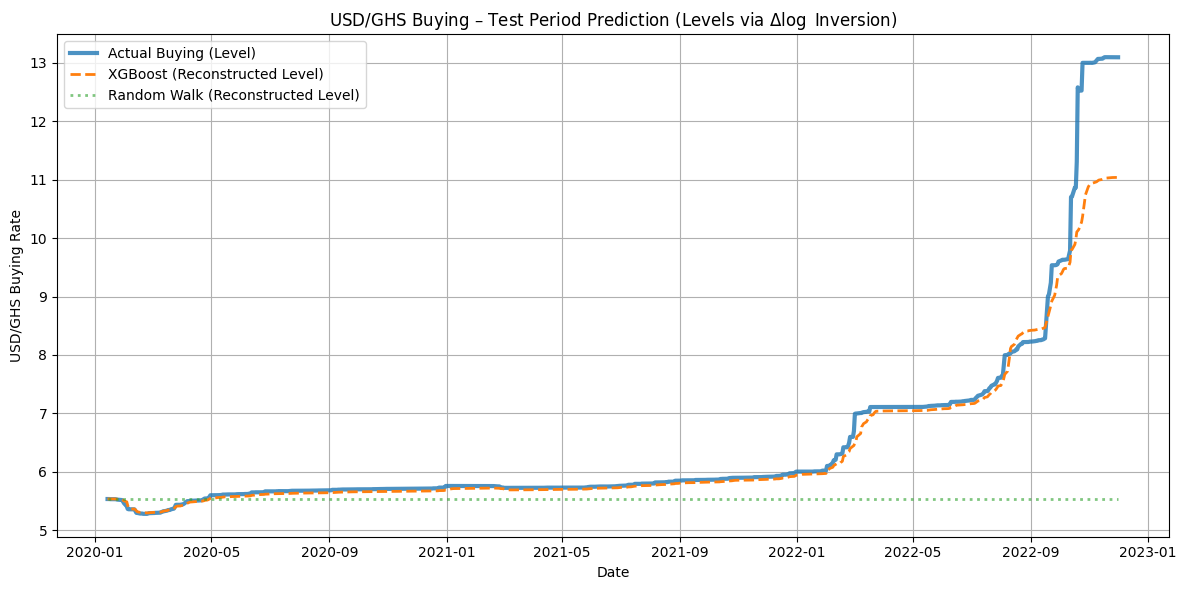

In [12]:
# 6.3 Plotting the Results
plt.figure(figsize=(12, 6))
plt.plot(true_level.index, true_level.values,
         label=f"Actual {Y_COL} (Level)", linewidth=3, alpha=0.8)
plt.plot(xgb_level.index, xgb_level.values,
         label="XGBoost (Reconstructed Level)", linestyle='--', linewidth=2)
plt.plot(rw_level.index,  rw_level.values,
         label="Random Walk (Reconstructed Level)", linestyle=':', linewidth=2, alpha=0.6)

plt.title(
    f"USD/GHS {Y_COL} – Test Period Prediction (Levels via $\Delta \log$ Inversion)")
plt.xlabel("Date")
plt.ylabel(f"USD/GHS {Y_COL} Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot for your records
plt.savefig(os.path.join(OUT_DIR, "xgb_fx_prediction.png"))
plt.show()